In [33]:
import networkx as nx
import pyro.distributions as dist
import matplotlib.pylab as plt
import numpy as np
import sys
sys.path.append("/home/folzd/phd/compositions_mixtures_factors")
from model_operators import *
from utils import *
from code_generation import *
from graph_grammar import *
from models_and_guides import *
from inference import *

In [3]:
%load_ext autoreload

%autoreload 2

In [162]:
factor = nx.DiGraph()

In [163]:
nodes = [
    #('z_loc',{'type':'const', 'value':0.}),
    #('z_scale',{'type':'const', 'value':1.}),
    ('z_loc',{'type':'function', 'function':torch.zeros, 'args':(Name(id='K'),)}),
    ('z_scale',{'type':'function', 'function':torch.ones, 'args':(Name(id='K'),)}),
    ('z',{'distribution':dist.Normal,'type':'latent','event_dims':1}),
    #('z_T',{'type':'deterministic', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    #('z_T',{'type':'function', 'function':torch.transpose, 'args':(Num(0),Num(1))}),
    ('cov_diag_loc',{'type':'param','shape':'D'}),
    ('cov_diag_scale',{'type':'param','shape':'D','constraint':'positive'}),
#    ('cov_factor_loc',{'type':'param','shape':'KD'}),
#    ('cov_factor_scale',{'type':'param','shape':'KD','constraint':'positive'}),
    ('cov_factor_loc',{'type':'param','shape':'DK'}),
    ('cov_factor_scale',{'type':'param','shape':'DK','constraint':'positive'}),
    ('cov_factor',{'distribution':dist.Normal,'type':'latent','event_dims':2}),
    #('Wz',{'type':'deterministic', 'function':torch.matmul}),
    ('Wz',{'type':'function', 'function':torch.matmul, 'args':('p','t')}),
    ('X',{'distribution':dist.MultivariateNormal,'type':'obs'}),
    ('cov_diag',{'distribution':dist.LogNormal,'type':'latent','event_dims':1}),
    #('diag',{'type':'deterministic', 'function':torch.diag_embed}),
    ('diag',{'type':'function', 'function':torch.diag_embed}),
]

In [164]:
edges = [
    ('cov_diag_loc','cov_diag',{'type':'param','param':'loc'}),
    ('cov_diag_scale','cov_diag',{'type':'param','param':'scale'}),
    ('cov_factor_loc','cov_factor',{'type':'param','param':'loc'}),
    ('cov_factor_scale','cov_factor',{'type':'param','param':'scale'}),
    ('z_loc','z',{'type':'param','param':'loc'}),
    ('z_scale','z',{'type':'param','param':'scale'}),    
    #('z','Wz',{'type':'arg', 'transpose':True}),
#    ('z','z_T',{'type':'arg'}),
#    ('z_T','Wz',{'type':'arg'}),
    ('z','Wz',{'type':'arg'}),
    ('cov_factor','Wz',{'type':'arg'}),
    ('Wz','X',{'type':'param','param':'loc'}),
    #('cov_diag','X',{'type':'param','param':'scale'})
    ('cov_diag','diag',{'type':'arg'}),
    ('diag','X',{'type':'param','param':'covariance_matrix'})
]

In [165]:
plate_attr = {
#    'cov_factor':{'plates':['D','K']},
#    'cov_diag':{'plates':['D']},
    'X':{'plates':['N']},
    'Wz':{'plates':['N']},
    #'z':{'plates':['N','K']},
    'z':{'plates':['N']},
    #'z_T':{'plates':['N']}
}

In [166]:
factor.add_nodes_from(nodes)
factor.add_edges_from(edges)
nx.set_node_attributes(factor, plate_attr)

W: D, K

z: K, N

Sigma: D

Wz: N

X: N

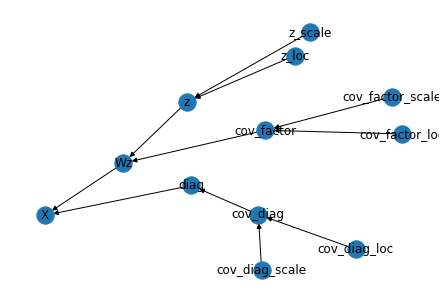

In [171]:
nx.draw(factor, with_labels=True)

In [172]:
marg_factor = marginalize_factor(factor)

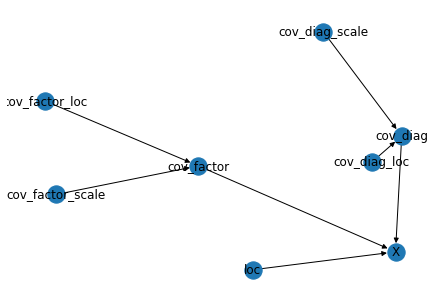

In [173]:
nx.draw(marg_factor, with_labels=True)

In [406]:
mixture = mixture_from_marg_factor(marg_factor)

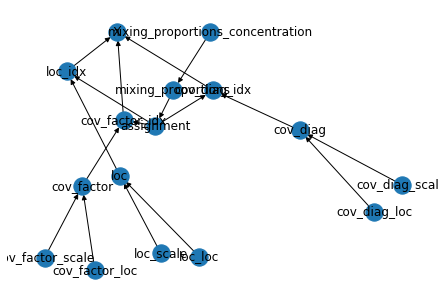

In [407]:
nx.draw(mixture, with_labels=True)

In [408]:
nx.get_node_attributes(mixture, 'plates')

{'cov_diag_loc': ['C'],
 'cov_diag_scale': ['C'],
 'cov_factor_loc': ['C'],
 'cov_factor_scale': ['C'],
 'cov_factor': ['C'],
 'X': ['N'],
 'cov_diag': ['C'],
 'loc': ['C'],
 'assignment': ['N'],
 'cov_factor_idx': ['N'],
 'cov_diag_idx': ['N'],
 'loc_idx': ['N']}

In [409]:
nx.get_node_attributes(mixture, 'shape')

{'cov_diag_loc': 'CD',
 'cov_diag_scale': 'CD',
 'cov_factor_loc': 'CDK',
 'cov_factor_scale': 'CDK',
 'mixing_proportions_concentration': 'C',
 'loc_loc': 'CD',
 'loc_scale': 'CD'}

In [410]:
#generate_Model_class(marg_factor)
generate_Model_class(mixture)

In [411]:
from model import DAGModel

In [412]:
pyro.clear_param_store()
N = 1000
D = 3
K = 4
C = 2
dagmodel = DAGModel(torch.zeros(N,D),K,C,N,'id')
tmp = dagmodel.model(torch.zeros(N,D))

In [413]:
dagmodel.param_shapes_and_support

{'loc_scale_init_id': ((2, 3), GreaterThan(lower_bound=0.0)),
 'loc_prior_scale_init_id': ((2, 3), GreaterThan(lower_bound=0.0)),
 'loc_loc_init_id': ((2, 3), Real()),
 'loc_prior_loc_init_id': ((2, 3), Real()),
 'mixing_proportions_concentration_init_id': ((2,),
  GreaterThan(lower_bound=0.0)),
 'mixing_proportions_prior_concentration_init_id': ((2,),
  GreaterThan(lower_bound=0.0)),
 'cov_factor_scale_init_id': ((2, 3, 4), GreaterThan(lower_bound=0.0)),
 'cov_factor_prior_scale_init_id': ((2, 3, 4), GreaterThan(lower_bound=0.0)),
 'cov_factor_loc_init_id': ((2, 3, 4), Real()),
 'cov_factor_prior_loc_init_id': ((2, 3, 4), Real()),
 'cov_diag_scale_init_id': ((2, 3), GreaterThan(lower_bound=0.0)),
 'cov_diag_prior_scale_init_id': ((2, 3), GreaterThan(lower_bound=0.0)),
 'cov_diag_loc_init_id': ((2, 3), Real()),
 'cov_diag_prior_loc_init_id': ((2, 3), Real())}

In [414]:
dgp = dagmodel.unconditioned_model
trace = pyro.poutine.trace(dgp).get_trace(torch.empty(N,D))
true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])

new_dgp = pyro.poutine.condition(dgp, data={'loc_id':true_variables['loc_id']*3})
trace = pyro.poutine.trace(new_dgp).get_trace(torch.empty(N,D))

true_variables = dict([(name,trace.nodes[name]["value"]) for name in trace.stochastic_nodes if len(name)>1])
X = true_variables['obs'].detach()
Xz = torch.cat([X,true_variables['assignment_id'].detach().float().unsqueeze(-1)],dim=-1)
Xzdata, Xztest_data = train_test_split(Xz)
data, train_assign = Xzdata[:,:-1],Xzdata[:,-1]
test_data, test_assign = Xztest_data[:,:-1],Xztest_data[:,-1]

In [415]:
X.shape

torch.Size([1000, 3])

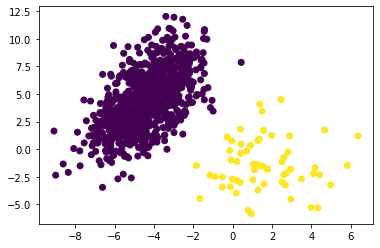

In [428]:
rand_idx = np.random.choice(D,2, replace=False)

rand_idx

plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
#plt.scatter(*foo['obs'][:,0,0,rand_idx].squeeze().T.detach())

In [420]:
config = dict(
        n_iter = 10000,
        learning_rate = 0.01, 
        beta1 = 0.9,
        beta2 = 0.999,
        learning_rate_decay = 1., # no decay by default
        batch_size = 32, 
        n_elbo_particles = 1, 
        n_posterior_samples = 1024,
        window = 500,
        convergence_window = 30,
        slope_significance = 0.1,
        track_params = False,
        monitor_gradients = False,
        telemetry = None
    )

In [421]:
telemetry = inference(dagmodel, data, test_data, config=config)



NLL after 0/10000 iterations is 8.884256362915039
....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

NLL after 7500/10000 iterations is 6.235870838165283


............................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [422]:
dagmodel.sample_posterior_predictive(N)

In [423]:
foo = dagmodel.posterior_predictive(data)

foo['obs'].shape

torch.Size([1000, 32, 3])

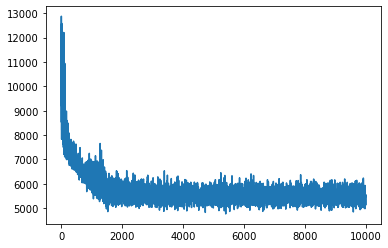

In [424]:
plt.plot(telemetry['loss'])

In [425]:
foo['obs'].shape

torch.Size([1000, 32, 3])

In [426]:
foo['assignment_id'].shape

torch.Size([1000, 32])

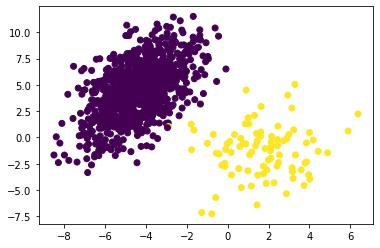

In [429]:
#plt.scatter(*data[:,rand_idx].T)
#plt.scatter(*foo['obs'][:,0,0,0,rand_idx].squeeze().T.detach())

#plt.scatter(*data[:,rand_idx].T,c=train_assign.squeeze())
plt.scatter(*foo['obs'][:,0,rand_idx].squeeze().T.detach(),c=foo['assignment_id'][:,0].squeeze().T.detach())
